# __Final Project Report:__
## Will Clean Energy Ever Replace Unclean Energy?

By: Daniel Knopp, Peter LeCavelier, Ryan Hensel, Kenzie Hensel, Sierra Rose

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Define a Hill sigmoidal function to use for curve fitting later
def hill_sigmoid(x, a, b, c):
    return  a * np.power(x, b) / (np.power(c, b) + np.power(x, b)) 

In [3]:
# import anual energy production by source data
e_production_by_source = pd.read_csv('annual_e_prod_by_source.csv')

# import anual energy consumption by source data
e_consumption_by_source = pd.read_csv('annual_e_cons_by_source.csv')

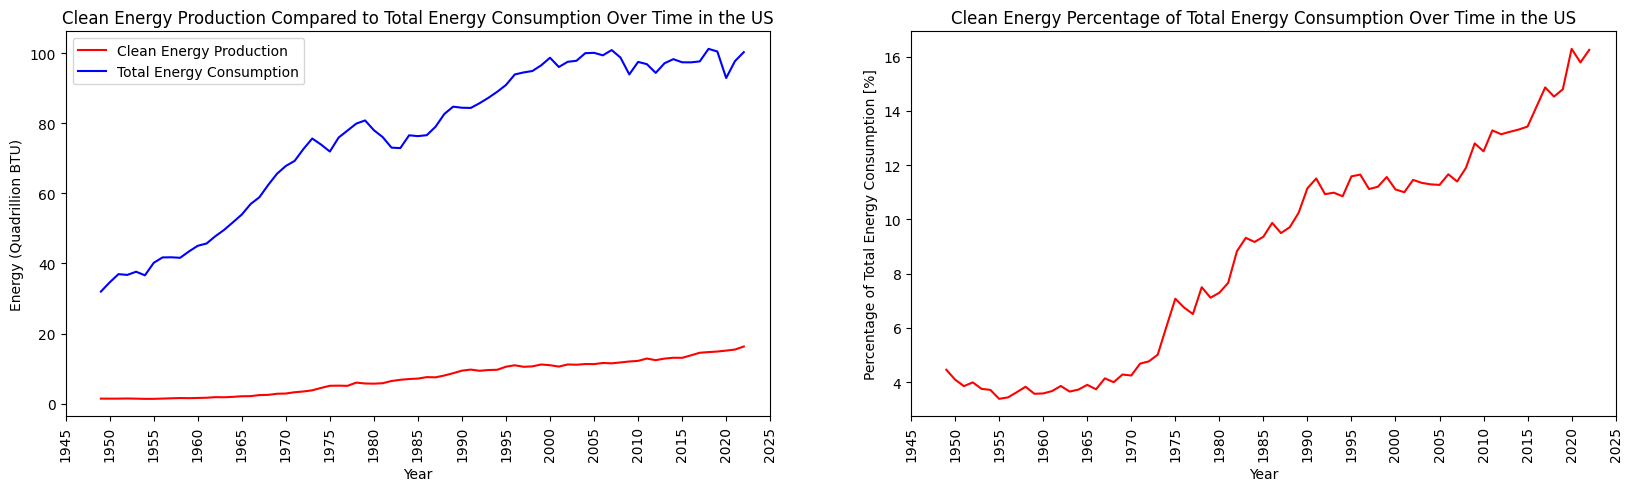

In [15]:
# Create list of energy categorized as clean energy
clean_energy = ['Nuclear', 'Solar', 'Wind', 'Hydroelectric', 'Geothermal', 'Annual Total']

cols = e_production_by_source.columns
cols_to_keep = [col for col in cols for clean in clean_energy if clean in col]

# Create a new dataframe with only the clean energy columns
clean_energy = e_production_by_source[cols_to_keep]

# Change all Not Available to zero
clean_energy = clean_energy.replace('Not Available', 0)

# Cast all values to float
clean_energy = clean_energy.astype(float)

# Create a new column that sums all the clean energy sources
clean_energy['Total'] = clean_energy.sum(axis=1) - clean_energy['Annual Total']

# Create a 1x2 subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot the clean energy production over time on first subplot
ax[0].plot(clean_energy['Annual Total'], clean_energy['Total'], color='r', label='Clean Energy Production')
ax[0].plot(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], color='b', label='Total Energy Consumption')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Energy (Quadrillion BTU)')
ax[0].legend()
ax[0].set_xlim(1945, 2025)
ax[0].set_xticks(np.arange(1945, 2026, 5))
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Clean Energy Production Compared to Total Energy Consumption Over Time in the US')

# Plot clean energy production as a percentage of total energy consumption on second subplot
ax[1].plot(clean_energy['Annual Total'], clean_energy['Total'] / e_consumption_by_source['Total Primary Energy Consumption'] * 100, color='r', label='Clean Energy Production')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Percentage of Total Energy Consumption [%]')
ax[1].set_xlim(1945, 2025)
ax[1].set_xticks(np.arange(1945, 2026, 5))
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('Clean Energy Percentage of Total Energy Consumption Over Time in the US')

plt.show()


The trendlines cross in 2269.


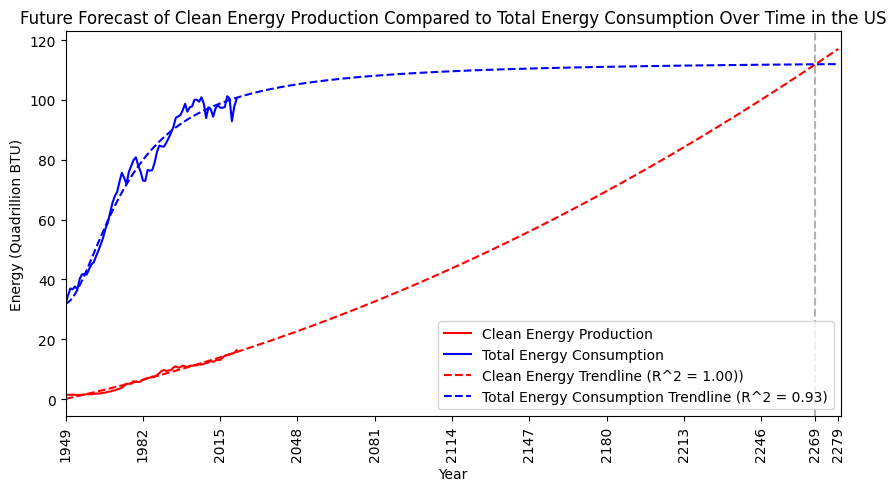

In [5]:
# Create a list of years to forecast trendlines out to 2050
xmin = e_consumption_by_source['Annual Total'][0]
xmax = 2280
future_years = np.arange(xmin, xmax, 1)
ticks = np.arange(xmin, xmax+1, round((xmax - xmin) / 10))

# Create a trendline for the clean energy data as a polynomial and store the R^2 value
predictive_clean_fit = np.polyfit(clean_energy['Annual Total'], clean_energy['Total'], 2)
r_squared_clean      = np.corrcoef(clean_energy['Annual Total'], np.polyval(predictive_clean_fit, clean_energy['Annual Total']))[0, 1] ** 2
predictive_clean_val = np.polyval(predictive_clean_fit, future_years)

# Perform curve fitting using the logarithmic function defined earlier for total energy consumption
total_start_year = xmin
total_start_energy = e_consumption_by_source['Total Primary Energy Consumption'][0]
popt, pcov = curve_fit(hill_sigmoid, e_consumption_by_source['Annual Total'] - total_start_year, e_consumption_by_source['Total Primary Energy Consumption'] - total_start_energy, p0=[1, 1, 1])

# Create a trendline for the total energy consumption data as a 3rd order polynomial and store the R^2 value
predictive_total_fit = np.polyfit(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], 3)
r_squared_total      = np.corrcoef(e_consumption_by_source['Annual Total'], np.polyval(predictive_total_fit, e_consumption_by_source['Annual Total']))[0, 1] ** 2
predictive_total_val = hill_sigmoid(future_years - total_start_year, popt[0], popt[1], popt[2]) + total_start_energy

# Plot the trendlines
plt.figure(figsize=(10, 5))
plt.plot(clean_energy['Annual Total'], clean_energy['Total'], color='r', label='Clean Energy Production')
plt.plot(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], color='b', label='Total Energy Consumption')
plt.plot(future_years, predictive_clean_val, color='r', linestyle='--', label=f'Clean Energy Trendline (R^2 = {r_squared_clean:.2f}))')
# plt.plot(future_years, np.polyval(predictive_total, future_years), color='b', linestyle='--', label=f'Total Energy Consumption Trendline (R^2 = {r_squared_total:.2f})')
plt.plot(future_years, predictive_total_val, color='b', linestyle='--', label=f'Total Energy Consumption Trendline (R^2 = {r_squared_total:.2f})')
plt.xlabel('Year')
plt.ylabel('Energy (Quadrillion BTU)')
plt.legend()
plt.xlim(xmin, xmax)
plt.xticks(ticks, rotation=90)
plt.title('Future Forecast of Clean Energy Production Compared to Total Energy Consumption Over Time in the US')

# Get the closest point on both trendlines
closes_val = min(abs(predictive_total_val - predictive_clean_val))

# Get the year the trendlines cross
cross_year = future_years[abs(predictive_total_val - predictive_clean_val) == closes_val][0]

# Print the year the trendlines cross
print(f'The trendlines cross in {cross_year:.0f}.')

# Add a dotted vertial grey line at the year the trendlines cross with 0.6 transparency
plt.axvline(x=cross_year, color='grey', linestyle='--', alpha=0.6)

# Add an additional tick label at the year the trendlines cross
plt.xticks(np.append(ticks, cross_year), rotation=90)
plt.show()
